<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter4/4_1_%E3%82%AB%E3%82%99%E3%82%A6%E3%82%B9%E6%B7%B7%E5%90%88%E3%83%A2%E3%83%86%E3%82%99%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title install packages
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [2]:
#@title Import packages
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import arviz as az
import pymc3 as pm
# import pymc3.sampling_jax

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

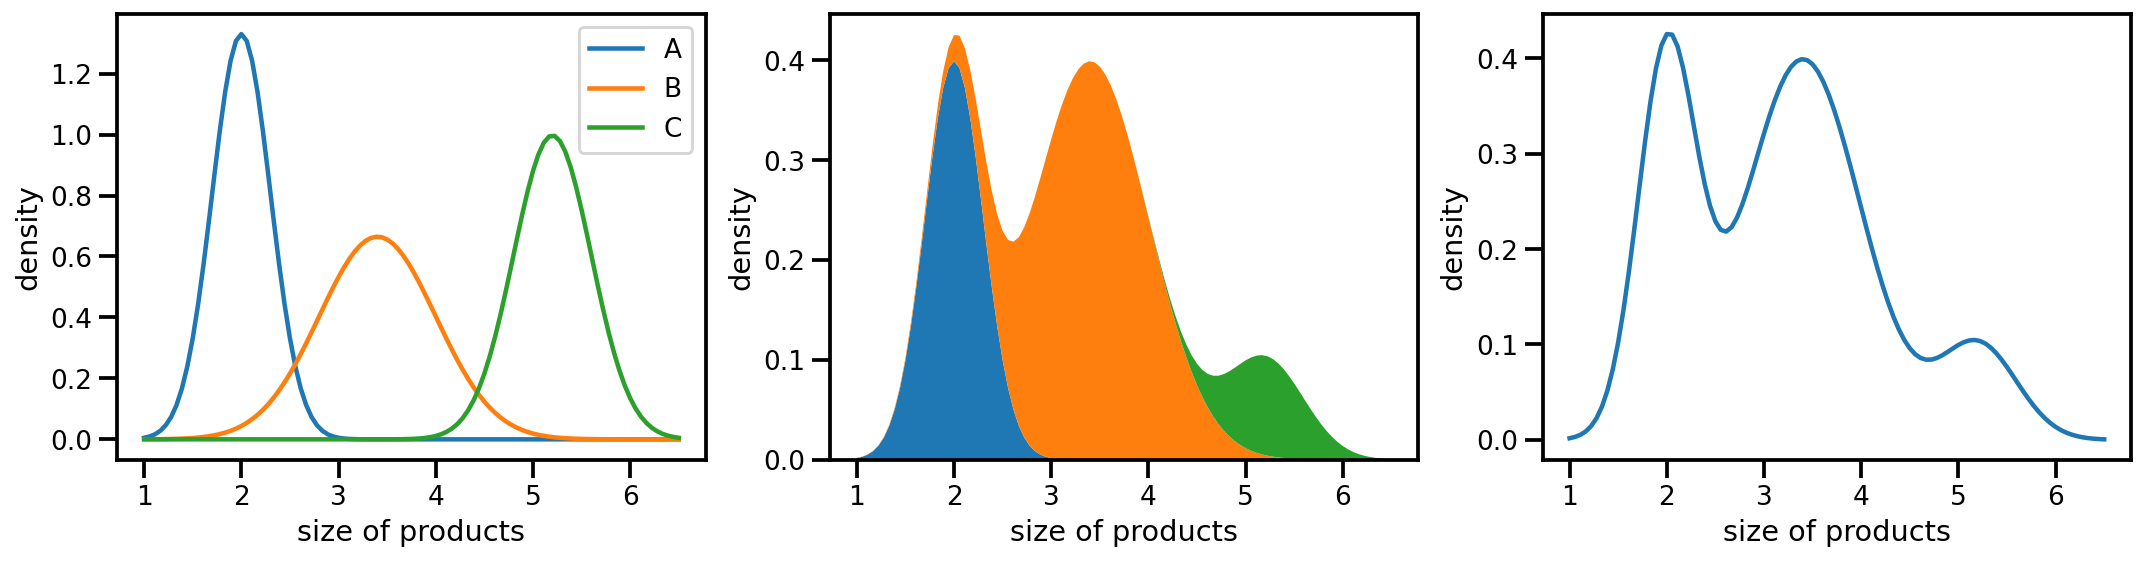

In [3]:
#@title 1d mixture distribution
pi_list = np.array([0.3, 0.6, 0.1])
mu_list = np.array([2.0, 3.4, 5.2])
sigma_list = np.array([0.3, 0.6, 0.4])
labels = ['A', 'B', 'C']

xx = np.linspace(1, 6.5, 100)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
probs = []
for mu, sigma, label in zip(mu_list, sigma_list, labels):
    p = stats.norm(mu, sigma).pdf(xx)
    axes[0].plot(xx, p, label=label)
    probs.append(p)

probs = np.array(probs)
axes[0].legend()
axes[1].stackplot(xx, *(pi_list[:,np.newaxis] * probs))
axes[2].plot(xx, (pi_list[:,np.newaxis] * probs).sum(axis=0))

for ax in axes:
    ax.set_xlabel('size of products')
    ax.set_ylabel('density')

plt.tight_layout()

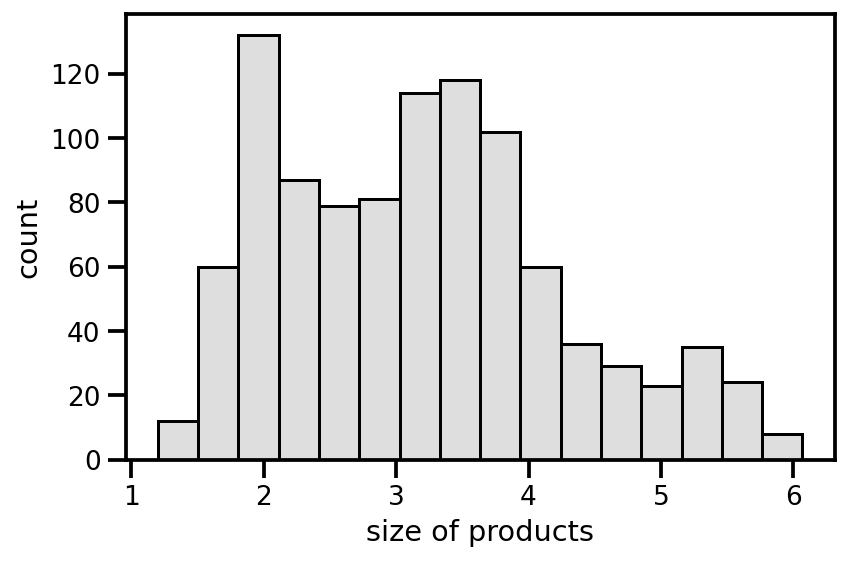

In [4]:
#@title 1d mixture distribution
n_sample = 1000
components = 3

pi_list = np.array([0.3, 0.6, 0.1])
mu_list = np.array([2.0, 3.4, 5.2])
sigma_list = np.array([0.3, 0.6, 0.4])

np.random.seed(1)
latent = np.random.choice(components, size=n_sample, p=pi_list)
data = np.random.normal(mu_list[latent], sigma_list[latent])

fig, ax = plt.subplots()
sns.histplot(data, color='lightgray', ax=ax)
# sns.histplot(data, stat='density', color='lightgray', ax=ax)
# ax.plot(xx, (pi_list[:,np.newaxis] * probs).sum(axis=0), lw=3)
ax.set_xlabel('size of products')
ax.set_ylabel('count')

plt.tight_layout()

In [5]:
n_sample = 1000
K = 3

with pm.Model() as model:
    # 混合比率
    pi = pm.Dirichlet("pi", a=np.ones(K), shape=K)
    
    # クラスタごとの正規分布の平均(shapeに合わせてブロードキャストされる)
    mu = pm.Normal("mu", mu=0, sigma=10, shape=K)
    
    # クラスタごとの正規分布の標準偏差(shapeに合わせてブロードキャストされる)
    sigma = pm.HalfCauchy("sigma", beta=3, shape=K)

    # クラスタ割り当てを示す潜在変数
    z = pm.Categorical("z", p=pi, shape=n_sample)

    # 観測モデル
    x = pm.Normal("x", mu=mu[z], sigma=sigma[z], observed=data)

In [6]:
# 20分ほどかかるので要注意
with model:
    trace = pm.sample(5000, tune=1000, chains=1, random_seed=1, return_inferencedata=True)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [sigma, mu, pi]
>CategoricalGibbsMetropolis: [z]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 1251 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


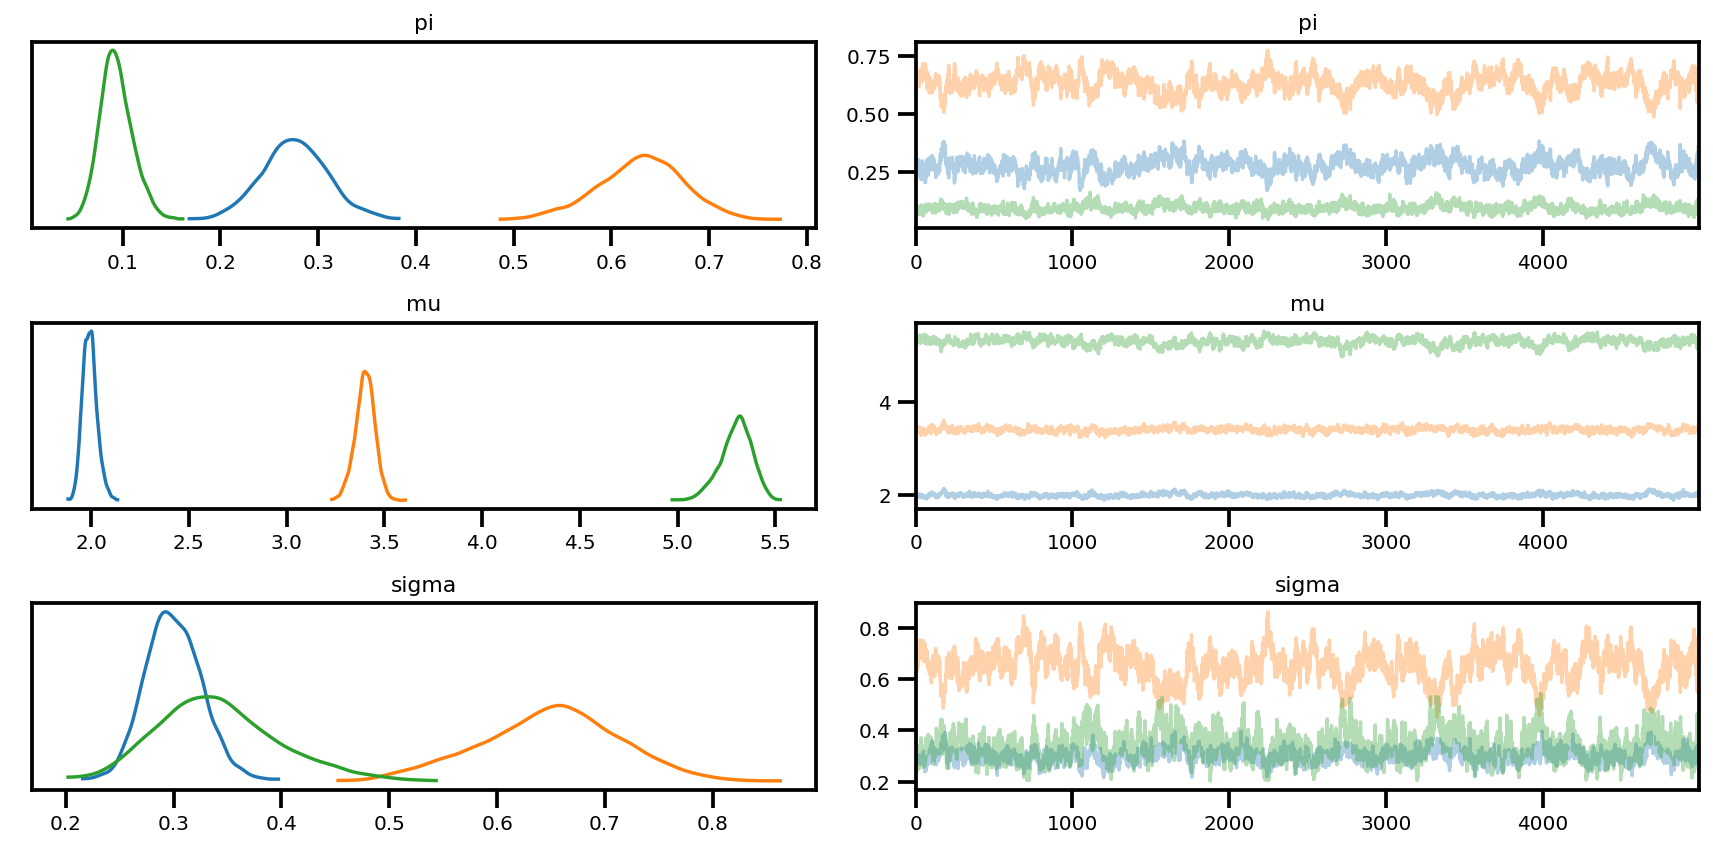

In [7]:
az.plot_trace(trace, var_names=['pi', 'mu', 'sigma'])
plt.tight_layout()

In [8]:
display(az.summary(trace, var_names=['pi', 'mu', 'sigma'], kind='stats'))

print(f'true mix probs:\n{pi_list}\n')
print(f'true mean:\n{mu_list}\n')
print(f'true sd:\n{sigma_list}')

,mean,sd,hdi_3%,hdi_97%
pi[0],0.276,0.033,0.213,0.342
pi[1],0.630,0.043,0.541,0.706
pi[2],0.094,0.017,0.063,0.126
mu[0],1.994,0.036,1.930,2.066
mu[1],3.402,0.050,3.300,3.491
mu[2],5.300,0.081,5.140,5.444
sigma[0],0.300,0.026,0.252,0.349
sigma[1],0.650,0.064,0.526,0.768
sigma[2],0.340,0.056,0.241,0.451


true mix probs:
[0.3 0.6 0.1]

true mean:
[2.  3.4 5.2]

true sd:
[0.3 0.6 0.4]


In [9]:
z_samples = trace.posterior['z'][0].values
# データ点について、各クラスタが割り当てられた回数
label_counts = np.vstack([(z_samples == i).sum(axis=0) for i in range(K)]).transpose()
# データ点が各クラスタに属する確率
label_probs = label_counts / 5000
label_probs[:5]

array([[0.000e+00, 9.996e-01, 4.000e-04],
       [8.000e-04, 9.992e-01, 0.000e+00],
       [7.434e-01, 2.566e-01, 0.000e+00],
       [0.000e+00, 9.990e-01, 1.000e-03],
       [9.192e-01, 8.080e-02, 0.000e+00]])

index: 2, value: 2.244


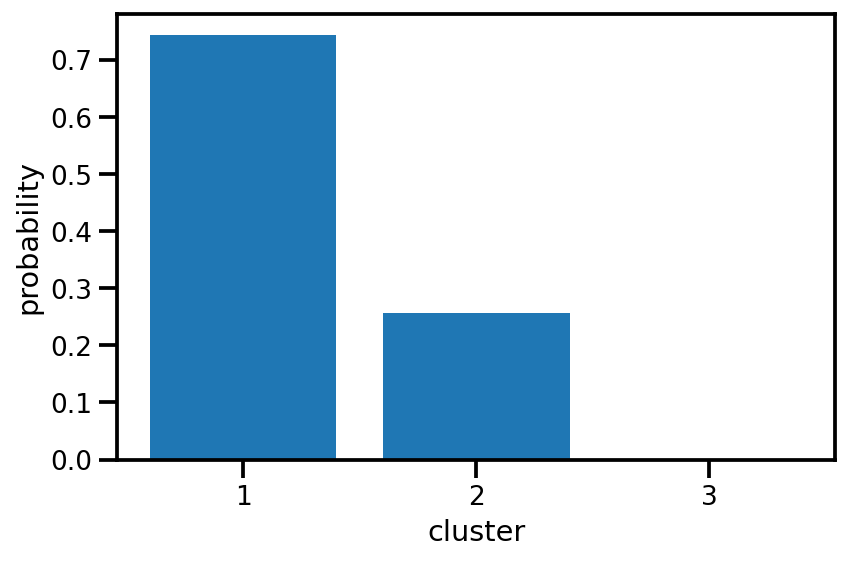

In [10]:
i = 2

print(f'index: {i}, value: {data[i]:.3f}')
plt.bar(['1', '2', '3'], label_probs[i])
plt.xlabel('cluster')
plt.ylabel('probability')
plt.tight_layout()

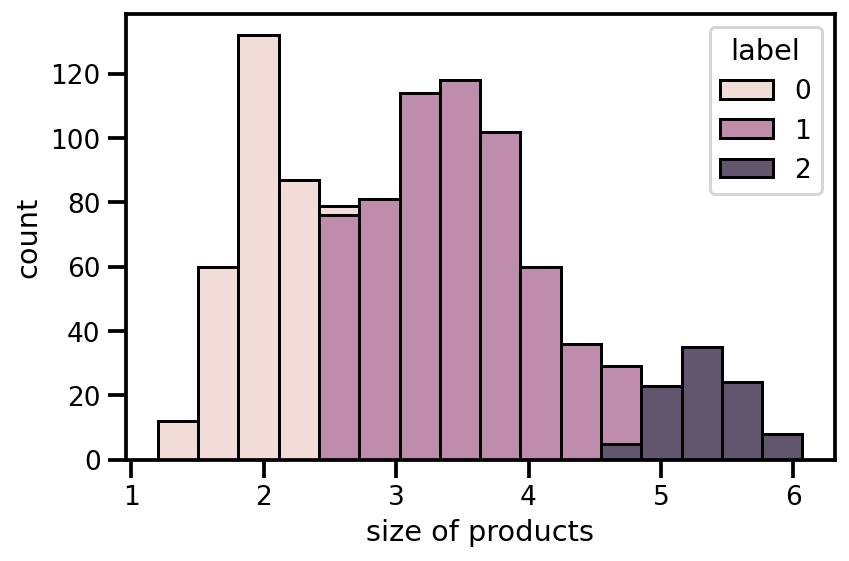

In [11]:
# 確率最大のクラスタを選択
label_preds = label_probs.argmax(axis=1)

preds = pd.DataFrame(dict(x=data, label=label_preds))
sns.histplot(preds, x='x', hue='label', multiple='stack')
plt.xlabel('size of products')
plt.ylabel('count')
plt.tight_layout()

## 潜在変数を周辺化するケース
書籍ではPyMC3が離散変数を扱えることの例示として、時間はかかるもののあえて潜在変数を周辺化せずに扱っていました。周辺化する場合のコード例を紹介します。

参考リンク：https://docs.pymc.io/en/v3/pymc-examples/examples/mixture_models/marginalized_gaussian_mixture_model.html  

（追加予定）



In [12]:
%load_ext watermark
%watermark --iversions

IPython   : 5.5.0
scipy     : 1.4.1
matplotlib: 3.2.2
numpy     : 1.21.6
pandas    : 1.3.5
arviz     : 0.12.1
seaborn   : 0.11.2
pymc3     : 3.11.4

